In [11]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('covid_100_pts.csv', delimiter=',') #in the form of [t,S,I,D,R]

torch.manual_seed(1234)

In [12]:
%%time

PATH = 'covid_layers4_neurons10_' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 59e6 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.save = 3 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.191
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.05
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.0294
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #unnormalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda)*0.191*20

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)*0.05*20
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)*0.0294*20


    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 10) #takes 100 t's
            self.fc2=nn.Linear(10, 10)
            self.fc3=nn.Linear(10, 10)
            self.fc4=nn.Linear(10, 10)
            self.out=nn.Linear(10, 4) #outputs S, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)


        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                torch.mean(torch.square(self.I_hat - I_pred))+
                torch.mean(torch.square(self.D_hat - D_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(f1))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))
                ) 

        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 100 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('alpha: (goal 0.191 ', self.alpha)
          print('beta: (goal 0.05 ', self.beta)
          print('gamma: (goal 0.0294 ', self.gamma)

      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

CPU times: user 69 µs, sys: 0 ns, total: 69 µs
Wall time: 73.4 µs


In [13]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], 
            sidr_data[4]) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(700000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(700000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(700000) #train


loading pre-trained model...

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
alpha: (goal 0.191  tensor([0.1954], grad_fn=<MulBackward0>)
beta: (goal 0.05  tensor([0.0494], grad_fn=<MulBackward0>)
gamma: (goal 0.0294  tensor([0.0290], grad_fn=<MulBackward0>)

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000
alpha: (goal 0.191  tensor([0.1954], grad_fn=<MulBackward0>)
beta: (goal 0.05  tensor([0.0495], grad_fn=<MulBackward0>)
gamma: (goal 0.0294  tensor([0.0289], grad_fn=<MulBackward0>)

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000
alpha: (goal 0.191  tensor([0.1953], grad_fn=<MulBackward0>)
beta: (goal 0.05  tensor([0.0496], grad_fn=<MulBackward0>)
gamma: (goal 0.0294  tensor([0.0289], grad_fn=<MulBa

(Text(0, 0.5, 'Loss'),)

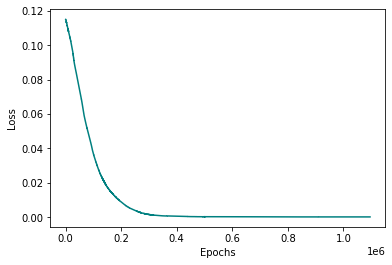

In [14]:
plt.plot(dinn.losses[300000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss'),

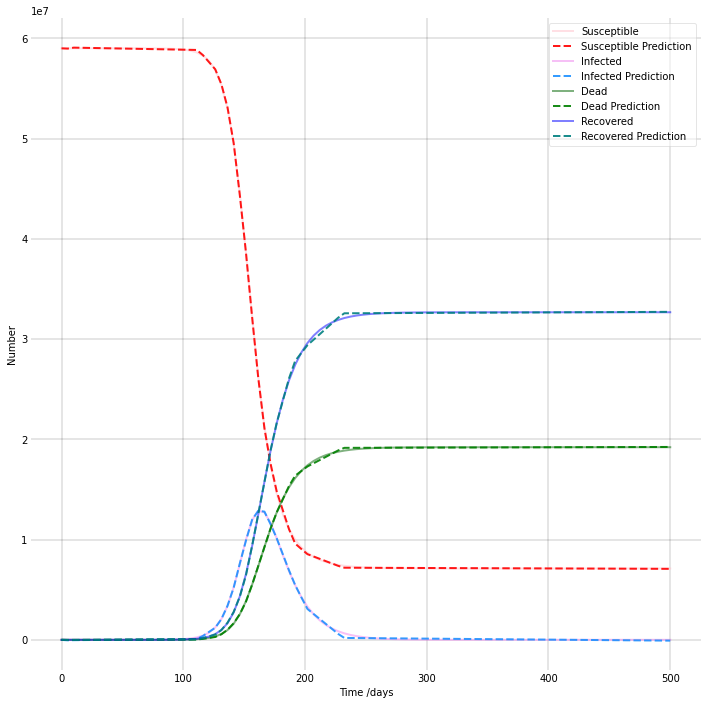

In [15]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')


ax.plot(sidr_data[0], sidr_data[1], 'pink', alpha=0.5, lw=2, label='Susceptible')
ax.plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax.plot(sidr_data[0], sidr_data[2], 'violet', alpha=0.5, lw=2, label='Infected')
ax.plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax.plot(sidr_data[0], sidr_data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead')
ax.plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax.plot(sidr_data[0], sidr_data[4], 'blue', alpha=0.5, lw=2, label='Recovered')
ax.plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('itswhite.pdf')
plt.show()

In [16]:
#calculate relative MSE loss
import math
import numpy as np

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0
t = np.linspace(0, 500, 100) 

for timestep in range(len(t)):
  S_value = sidr_data[1][timestep] - S_pred_list[0].detach().numpy()[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[1][timestep])**2
  I_value = sidr_data[2][timestep] - I_pred_list[0].detach().numpy()[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[2][timestep])**2
  D_value = sidr_data[3][timestep] - D_pred_list[0].detach().numpy()[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[3][timestep])**2
  R_value = sidr_data[4][timestep] - R_pred_list[0].detach().numpy()[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[4][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', I_total_loss)
print('D_total_loss: ', D_total_loss)
print('R_total_loss: ', R_total_loss)

S_total_loss:  0.002760936328037116
I_total_loss:  0.027039914731777553
D_total_loss:  0.004267704737584335
R_total_loss:  0.004292695470577578


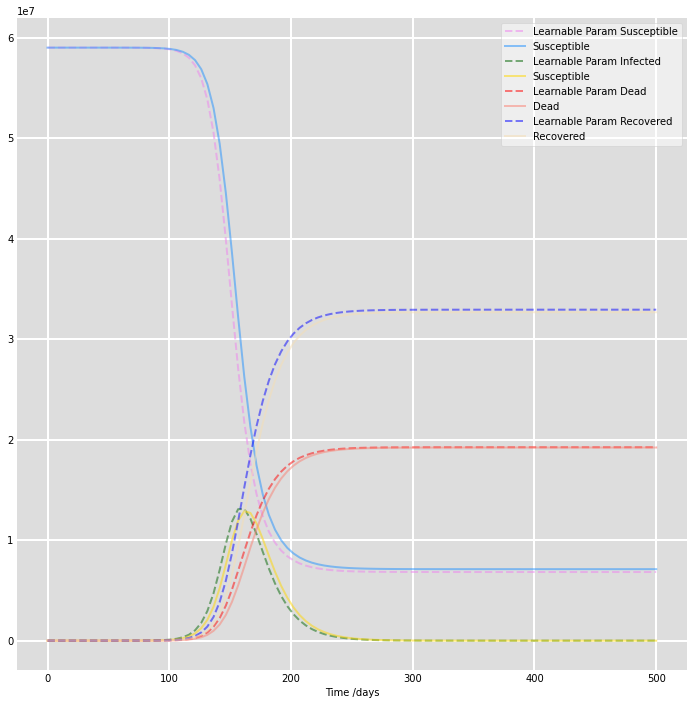

In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
N = 59e6

S0 = N - 1
I0 = 1
D0 = 0
R0 = 0
# A grid of time points (in days)
t = np.linspace(0, 500, 100) 

#parameters
alpha = dinn.alpha
beta = dinn.beta
gamma = dinn.gamma

# The SIR model differential equations.
def deriv(y, t, alpha, betta, gamma):
    S, I, D, R = y
    dSdt = - (alpha / N) * S * I
    dIdt = (alpha / N) * S * I - beta * I - gamma * I 
    dDdt = gamma * I
    dRdt = beta * I

    return dSdt, dIdt, dDdt, dRdt


# Initial conditions vector
y0 = S0, I0, D0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(alpha, beta, gamma))
S, I, D, R = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Learnable Param Susceptible', linestyle='dashed')
ax.plot(t, sidr_data[1], 'dodgerblue', alpha=0.5, lw=2, label='Susceptible')

ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Infected', linestyle='dashed')
ax.plot(t, sidr_data[2], 'gold', alpha=0.5, lw=2, label='Susceptible')

ax.plot(t, D, 'red', alpha=0.5, lw=2, label='Learnable Param Dead', linestyle='dashed')
ax.plot(t, sidr_data[3], 'salmon', alpha=0.5, lw=2, label='Dead')

ax.plot(t, R, 'blue', alpha=0.5, lw=2, label='Learnable Param Recovered', linestyle='dashed')
ax.plot(t, sidr_data[4], 'wheat', alpha=0.5, lw=2, label='Recovered')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [18]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[1][timestep])**2
  I_value = sidr_data[2][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[2][timestep])**2
  D_value = sidr_data[3][timestep] - D[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[3][timestep])**2
  R_value = sidr_data[4][timestep] - R[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[4][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', I_total_loss)
print('D_total_loss: ', D_total_loss)
print('R_total_loss: ', R_total_loss)

S_total_loss:  0.03803595857112454
I_total_loss:  0.1482759393948589
D_total_loss:  0.026586619784371757
R_total_loss:  0.02924119716478053
